<a href="https://colab.research.google.com/github/spinillac11/DeepLearning/blob/main/DL2A_lab_conv2D_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is  a follow up of the lab session on Fashion MNIST. Be sure you did and understood the previous notebook on applying the feed-forward neural network with pytorch.

The goal is to incrementally build an image classifier based on convolutional layers. Since we consider images and convolution we will use Tensors with peculiar shapes in input. Moreover, this session is also the occasion to introduce "Max-pooling" and to sue "Batch-normalization" again.




# Dataset

First get the dataset. This is the same as last lab.


In [ ]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# gzip
import gzip
import pickle



# To download the file:
! wget -nc --no-check-certificate "https://drive.usercontent.google.com/download?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN&confirm=t" -O "./fashion-mnist.pk.gz"

# Or if you prefer from Colab:
#import gdown
#url = 'https://drive.google.com/uc?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN'
#output = 'fashion-mnist.pk.gz'
#gdown.download(url, output, quiet=False)
# Load the dataset
fp = gzip.open('./fashion-mnist.pk.gz','rb')
allXtrain, allYtrain, Xvalid, Yvalid, classlist  = pickle.load(fp)

print(allXtrain.shape)
print(allYtrain.shape)
print(Xvalid.shape)
print(Yvalid.shape)
print(classlist)


File ‘./fashion-mnist.pk.gz’ already there; not retrieving.
torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


##  Data format

The provided version is unfortunately not adapted to our purpose in terms of dimensions.
*Convolution2D* expects as input a Tensor with 4 dimensions $(N,C,H,W)$ with :

- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 1
- H the height or number of rows of each image
- W the width  or number of columns of each image

## DataSet and DataLoader

In pytorch data handling is done in 2 steps:
- `DataSet`: a class to access the raw data, it can be tensors, files, distributed files, ...
- `DataLoader` (the class to iterate through the dataset and to get access to well prepared batch of data)

From the model viewpoint:
- During training and testing the model interacts with the `DataLoader` to go through the `DataSet`
- The Dataloader pick what is necessary in the `DataSet`  

Here we have Tensors, so we can use a `TensorDataSet`.  This abstraction for handling data is important. Depending on the application and the data types, it is very easier in practice to divide the process in two steps: the Dataset and the interaction between the model and the data via the dataset.





In [ ]:
BatchSize = 100
splittrain = 30000
# create your datset
#dataset = TensorDataset(x_tensor, y_tensor)
trainset = TensorDataset(allXtrain[:splittrain].view(splittrain,28,28), allYtrain[:splittrain])
# create your dataloader
# if you have also labels you do
trainloader = DataLoader(trainset,batch_size=BatchSize, shuffle=True)
# Do the same for the validation set
validset = TensorDataset(allXtrain[splittrain:].view(splittrain,28,28), allYtrain[splittrain:])
validloader = DataLoader(validset,batch_size=BatchSize, shuffle=True)

print(allXtrain[:splittrain].view(splittrain,28,28).shape)


torch.Size([30000, 28, 28])


To look at one batch :

In [ ]:
X, Y = next(iter(trainloader))
# Explore what you get as a batch

print(Y)

for x in X:
  print(x)
  break

tensor([3, 0, 8, 2, 8, 0, 2, 5, 7, 3, 5, 6, 0, 1, 2, 9, 0, 0, 5, 6, 5, 4, 9, 9,
        4, 7, 8, 1, 5, 7, 3, 4, 5, 6, 1, 6, 0, 4, 2, 3, 0, 9, 0, 3, 1, 5, 2, 0,
        3, 2, 5, 0, 9, 0, 4, 6, 4, 1, 9, 3, 6, 2, 9, 9, 4, 6, 4, 5, 5, 5, 1, 7,
        6, 2, 3, 5, 8, 7, 0, 5, 8, 9, 0, 1, 2, 7, 4, 8, 5, 3, 2, 8, 4, 6, 2, 4,
        4, 9, 1, 1])
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,
           0.,   0.,   0.,   0.,   9.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  93., 183., 207., 191.,
         119., 101., 104., 160., 208., 213., 154.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  38., 219., 210., 204., 217.,
         230., 232., 226., 219., 211., 212., 252., 109.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 104., 216., 195., 20

# Playing with convolution in 2D

Let start the exploration of convolution.The class we will use is called Conv2d. Read carefully the documentation of this module. Maybe you cannot understand everything. That's why it is useful to first play with the convolution with one image.

torch.Size([1, 1, 28, 28])
tensor(3)


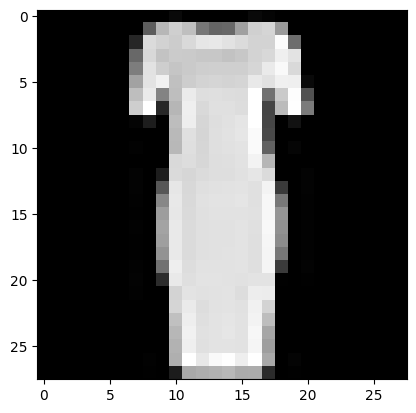

In [ ]:
# Extract one image to start and be sure you have the right dimensions.
print(X[0].unsqueeze(0).unsqueeze(0).shape)
print(Y[0])
plt.imshow(X[0].numpy(), matplotlib.pyplot.cm.gray)

Now create one convolution layer with 1 input channels, a kernel size of 3, and a stride of 1.
Try it and look at the output dimension.


In [ ]:
# TODO:
Xconv = X[0].unsqueeze(0).unsqueeze(0)
myConv = nn.Conv2d(1, 1, 3, stride=1)
conv_out = myConv(Xconv)
print(conv_out.shape)

torch.Size([1, 1, 26, 26])


The resulting "image" is not of the same dimension, how to obtain an output with the same dimension (same question with a kernel size of 5) ?

In [ ]:
# TODO
myConv = nn.Conv2d(1, 1, 3, stride=1, padding=1) #padding for adding 1 dmention
conv_out = myConv(Xconv)
print(conv_out.shape)


torch.Size([1, 1, 28, 28])


We can define the parameters of the convolutional filter with our own hands. For that purpose we just have to create the Tensor we want and cast it in a *Parameter* object (usefull for autograd) and then assign it.
This is an example:

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])


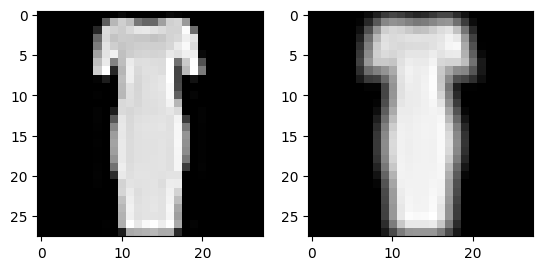

In [ ]:
# Create a convolutional filter
convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
# build the weight matrix you want
W=th.ones(convFilter.weight.shape)
print(W)
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W)

res = convFilter(Xconv)
plt.subplot(1,2,1)
plt.imshow(Xconv.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,2,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

Now try to set the convolution fiter as follows:
$$
\left(
\begin{array}{ccc}
 -1 &2&-1\\
 -1 &2&-1\\
 -1 &2&-1
\end{array}
\right)
$$
and then as follows:
$$
\left(
\begin{array}{rrr}
 -1 &-1&-1\\
 2 &2&2\\
 -1 &-1&-1
\end{array}
\right)
$$
Try them on some images and visualize the results.

tensor([[-1.,  2., -1.],
        [-1.,  2., -1.],
        [-1.,  2., -1.]])
tensor([[-1., -1., -1.],
        [ 2.,  2.,  2.],
        [-1., -1., -1.]])


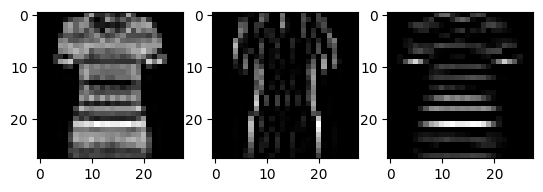

In [ ]:
from numpy._core.defchararray import count
# TODO
# build the weight matrix you want
W1=th.tensor([[-1., 2., -1], [-1., 2., -1], [-1., 2., -1]])
print(W1)
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W1.unsqueeze(0).unsqueeze(0))
Xtest = X[1].unsqueeze(0).unsqueeze(0)
res = convFilter(Xtest)

plt.subplot(1,3,1)
plt.imshow(Xtest.squeeze(),  matplotlib.pyplot.cm.gray)
plt.subplot(1,3,2)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

W2=th.tensor([[-1., -1., -1], [2., 2., 2], [-1., -1., -1]])
print(W2)
# Makes it a Parameter and assign
convFilter.weight = nn.Parameter(W2.unsqueeze(0).unsqueeze(0))
res = convFilter(Xtest)
plt.subplot(1,3,3)
plt.imshow(F.relu(res).squeeze().detach(), matplotlib.pyplot.cm.gray)

# Pool !

Now we introduce the max-pooling in 2 dimensions: *MaxPool2d*. Look at the documentation and then try to define the following pipeline:
- a convolution with a kernel size of 3, stride 1 and padding 1
- apply the ReLu function and
- a max pooling with kernel size of 2 and a stride of 2.
Try to guess before running your code the dimensions of the output !


In [ ]:
from torch.nn.modules import pooling
# TODO
Xconv = X[1].unsqueeze(0).unsqueeze(0)

convFilter = nn.Conv2d(in_channels=1,out_channels=1,
                       kernel_size = 3, padding=1,
                       stride=1)
outConv = convFilter(Xconv)
model = nn.ReLU()
pred = model(Xconv)
pooling = nn.MaxPool2d(2, stride=2)
poolling_out = pooling(Xconv)
print(poolling_out.shape)


torch.Size([1, 1, 14, 14])


#  A first model

After this interlude, the goal now is to write a class to implement the model with:

- 2D convolution with (kernel size = 3, padding = 1, stride 1)
- ReLu activation
- Max-pooling (kernel size = 2, stride 2)
- A final linear classifier
- The final activation

Writing this class, allows you to wrap what you have seen so far. To debug the model, you can first play step-by-step with each layer to ensure you obtain the right dimensions (it was done earlier). Then, write the class and run the training to evaluate the result (this what we have to do now).

The class inherits from an existing class of pytorch : *Module*. This mean: it is a *Module*, but we add some peculiarities. For that purpose we can fill the following code:

In [ ]:
# TODO
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding = 1, out_channels = 8):
        super(FashionCNN, self).__init__()
        # TODO : write the end of the constructor.
        # It is important to create here all the layers of the network.
        # All layers that have paramaters should be attribute.
        # For example:
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding)
        # TODO: add the rest
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.linear = nn.Linear(14*14*out_channels, 10)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        # TODO
        out_conv = self.conv(x)
        out_relu = self.relu(out_conv)
        out_maxpool = self.maxpool(out_relu)
        out_linear = self.linear(out_maxpool.view(-1, 14*14*8))
        output = self.activation(out_linear)
        # ...
        return output

In [ ]:
# Test the class: is everything in place:
# A first classifier is built like :
classif = FashionCNN()
# The parameters of the classifier are randomly initialize, but we
# can use it on a image :
im = X[1].unsqueeze(0).unsqueeze(0)
out = classif.forward(im)
print(out.shape) # the output has 2 dimensions
print(out)

# It is correct ? If not, correct the class to get the expected result.


torch.Size([1, 10])
tensor([[-5.2332e-05, -1.0233e+01, -5.1105e+01, -8.8428e+01, -1.1041e+01,
         -8.8263e+01, -3.8083e+01, -7.2800e+01, -3.6148e+01, -1.5312e+01]],
       grad_fn=<LogSoftmaxBackward0>)


# Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent. Like the previous lab session:
- we pick one training example
- compute the loss
- back-propagation of the gradient
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step. You can use for that purpose the training function we wrote earlier.


To train the CNN, we can reuse the training function you wrote carefully in the previous lab session. However we need to adapt it in order to use dataloaders (the `trainloader` and `validloader`)

Question:
- As optimizer we will use *Adam*. It is important to find the good choice of hyper-parameter for the initial learning rate. Try different values like 0.1, 0.01, ...
- Then try with a number of output channel set to 1, 8, 16.



In [ ]:
# TODO : paste here the training function you wrote before.
# Of course you can improve it if you want during the lab session.
# Especially in terms of parameters.

def training (Trainloader, Validloader, model, loss_fn, optimizer, Nepochs):
  training_loss_rec = []
  val_loss_rec = []
  accuracy_rec = []

  ## -----------> generic training loop <----------------
  for epoch in range(Nepochs):
    ## ------- training ------
    batch_training_loss = 0.0
    n_batches = 0

    for X, Y in Trainloader:
      optimizer.zero_grad()
      Y_pred = model.forward(X.unsqueeze(1)) #add 1 dimension to match model size
      training_loss = loss_fn(Y_pred,Y)
      training_loss.backward()
      optimizer.step()

      batch_training_loss += training_loss.item()
      n_batches += 1

    epoch_training_loss = batch_training_loss / n_batches # average loss
    training_loss_rec.append(epoch_training_loss)

    ## ------- validation ------
    bacth_val_loss = 0.0
    val_batches = 0
    correct = 0
    total = 0

    for Xv, Yv in Validloader:
      Y_pred_v = model.forward(Xv.unsqueeze(1))
      val_loss = loss_fn(Y_pred_v, Yv)

      bacth_val_loss += val_loss.item()
      val_batches += 1

      preds = th.argmax(Y_pred_v, dim=1)
      correct += (preds == Yv).sum().item()
      total += Yv.size(0)

    epoch_val_loss = bacth_val_loss / val_batches
    val_loss_rec.append(epoch_val_loss)

    if total > 0:
      epoch_val_acc = correct / total
    else:
      epoch_val_acc = 0.0

    accuracy_rec.append(epoch_val_acc)

  return training_loss_rec, val_loss_rec, accuracy_rec

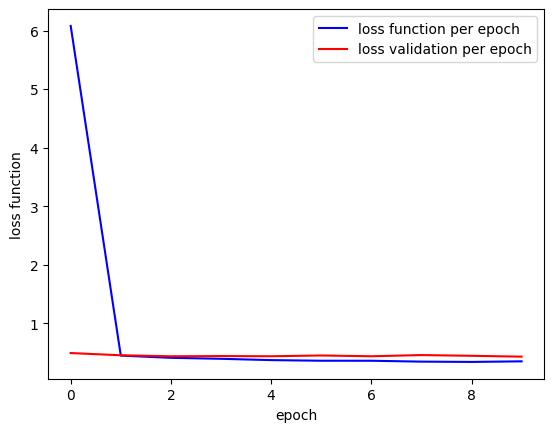

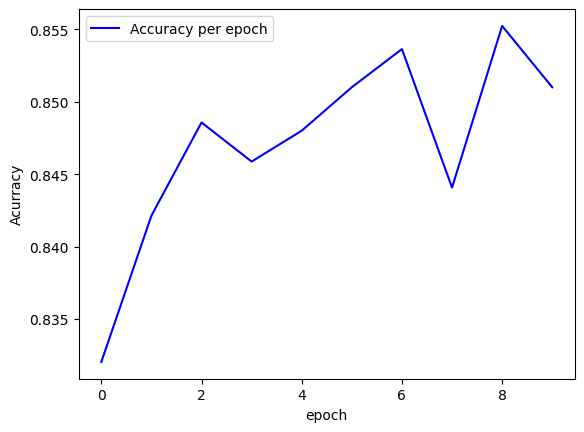

In [ ]:
# TODO
loss_fn=nn.NLLLoss()
model = FashionCNN()
adam = th.optim.Adam(model.parameters(), lr=0.008)
# Train you model !
NEPOCHS = 10

data_training, data_val, accuracy = training(trainloader, validloader, model, loss_fn, adam, NEPOCHS)


plt.plot(data_training, 'b', label = "loss function per epoch")
plt.plot(data_val, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

plt.plot(accuracy, 'b', label = "Accuracy per epoch")
plt.xlabel('epoch')
plt.ylabel('Acurracy')
plt.legend()
plt.show()


## Batch-norm

Extend your model to include the Batch-normalization.


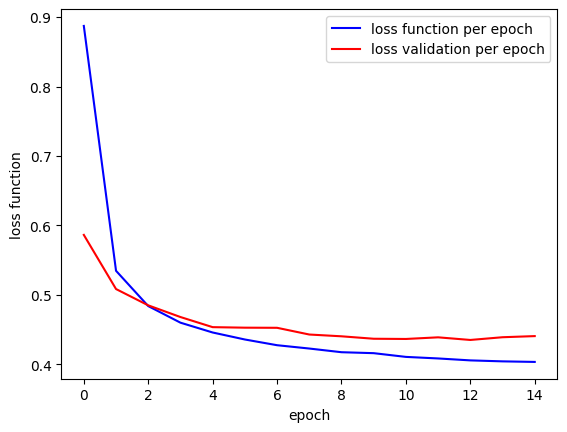

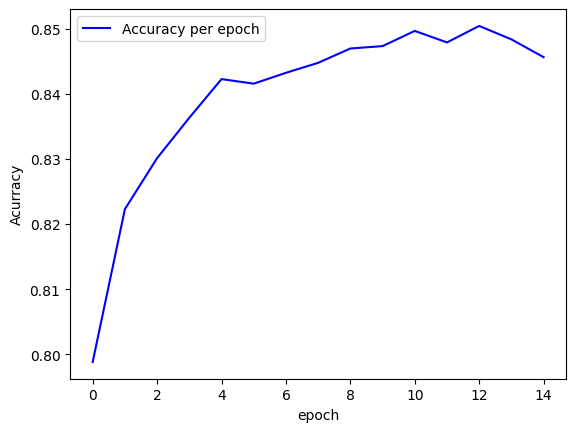

In [ ]:
# TODO
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding = 1, out_channels = 8):
        super(FashionCNN, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding)
        # TODO: add the rest
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.linear = nn.Linear(14*14*out_channels, 10)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        # TODO
        out_conv = self.conv(x)
        out_bn = self.bn(out_conv)
        out_relu = self.relu(out_bn)
        out_maxpool = self.maxpool(out_relu)
        out_linear = self.linear(out_maxpool.view(out_maxpool.size(0), -1))
        output = self.activation(out_linear)
        # ...
        return output

loss_fn=nn.NLLLoss()
model = FashionCNN()
adam = th.optim.Adam(model.parameters(), lr=0.001)
# Train you model !
NEPOCHS = 15

data_training, data_val, accuracy = training(trainloader, validloader, model, loss_fn, adam, NEPOCHS)


plt.plot(data_training, 'b', label = "loss function per epoch")
plt.plot(data_val, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

plt.plot(accuracy, 'b', label = "Accuracy per epoch")
plt.xlabel('epoch')
plt.ylabel('Acurracy')
plt.legend()
plt.show()

Whit out chanel > 1 we get a better accuracy but the loss of the validation set doesn't decreased with the train set  


## More convolution

We can now define an extended model where the basic block is : Conv2D, ReLu, BatchNorm and MaxPool.
We stack two blocks of this kind before the classification.

For instance in the previous model, this kind of block reduce the image size and increase the number of output channels. We can try to do the same and double this number in the second block.

TODO:
- Implement a model with two blocks as decribed above.
- We can then improve the output classifier.
- Play with the hyper-parameters.

Of course if you want to leverage a deeper model it is useful to increase the amount of training data (we only take the first 30k images until now).

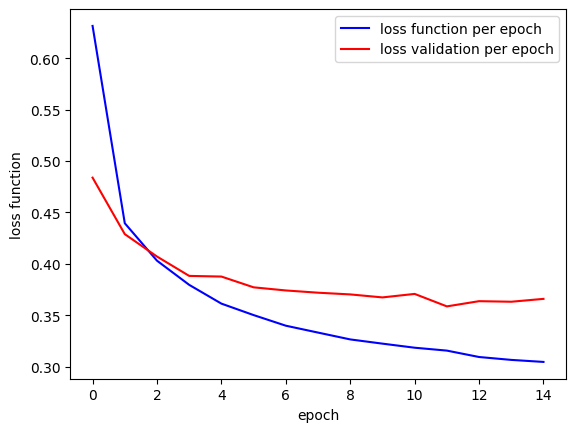

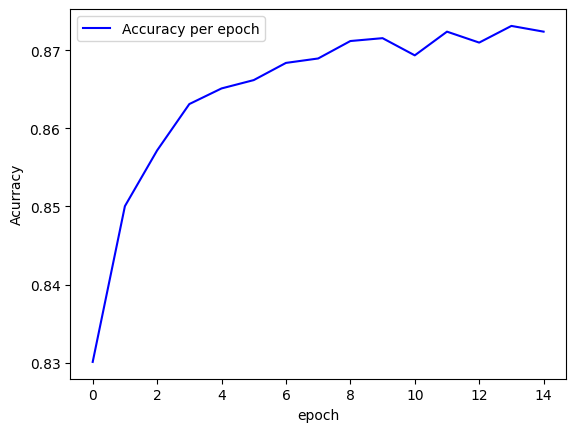

In [ ]:
# TODO
class FashionCNN(nn.Module):

    def __init__(self, kernel_size = 3, padding = 1, out_channels1 = 1, out_channels2 = 8):
        super(FashionCNN, self).__init__()

        ## ------- Block1 ------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels1, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        ## ------- Block2 ------
        self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels2)

        ## ------- classification ------
        self.linear = nn.Linear(out_channels2*7*7, 10)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out_conv1 = self.conv1(x)
        out_relu1 = self.relu(out_conv1)
        out_bn1 = self.bn1(out_relu1)
        out_maxpool1 = self.maxpool(out_bn1)

        out_conv2 = self.conv2(out_maxpool1)
        out_relu2 = self.relu(out_conv2)
        out_bn2 = self.bn2(out_relu2)
        out_maxpool2 = self.maxpool(out_bn2)
        out_linear = self.linear(out_maxpool2.view(out_maxpool2.size(0), -1))
        output = self.activation(out_linear)

        return output

loss_fn=nn.NLLLoss()
model = FashionCNN()
adam = th.optim.Adam(model.parameters(), lr=0.001)
NEPOCHS = 15

data_training, data_val, accuracy = training(trainloader, validloader, model, loss_fn, adam, NEPOCHS)


plt.plot(data_training, 'b', label = "loss function per epoch")
plt.plot(data_val, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

plt.plot(accuracy, 'b', label = "Accuracy per epoch")
plt.xlabel('epoch')
plt.ylabel('Acurracy')
plt.legend()
plt.show()

# And now in color: CIFAR-10


To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly:

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 72.1MB/s]


With this example we will use a **dataset** via a *dataloader*.  This is a convenient tool to handle datasets with efficient iterators.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

# Todo

Implement `VGG 16` architecture to get state of the art performance (see the course for the architecture)